# AI2619 Programming Homework 1

This homework is mainly about denoising and unblurring a manually processed image using [Wiener Filter](https://en.wikipedia.org/wiki/Wiener_filter).

*Author: Yikun Ji*

## Task 1

In this task, the image will be convolved with a [point spread function](https://en.m.wikipedia.org/wiki/Point_spread_function), the resulting image will be blurry compared to the original image.

In [1]:
# We use PIL.Image to decode the BMP file into a matrix
from PIL import Image
# We use numpy to perform convolution
import numpy as np
# We use matplotlib to show the output image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Implementing convolution from scratch

Despite the fact that packages like `opencv` and `torch` are providing highly usable convolution, here I implemented the convolution in Python from basic numeric operations to get a deeper understanding of the details under the hood.

For the first thing, convolution and cross-correlation are actually different. [This article](https://glassboxmedicine.com/2019/07/26/convolution-vs-cross-correlation/) helped me a lot as I'm implementing the algorithm from the math formula for convolution. Meanwhile, previous experience working with neural networks encourages me to implement the `padding` feature as well. Here is the implementation.

In [2]:
def convolve2D(image, kernel, padding=0):
    """Convolves two numpy arrays.

    Args:
      image: The original image.
      kernel: The convolution kernel.
      stride: The stride of the convolution process, defaults to 1.

    Returns:
      The resulting image as a numpy array.

    Raises:
      ValueError: Invalid stride given.
    """
    # Not Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((xImgShape + padding*2, yImgShape + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(yOutput):
        # Exit Convolution
        if y > yImgShape - yKernShape + 2 * padding:
            break
        # Only Convolve if y has gone down by the specified Strides
        for x in range(xOutput):
            # Go to next row once kernel is out of bounds
            if x > xImgShape - xKernShape + 2 * padding:
                break
            try:
                # Only Convolve if x has moved by the specified Strides
                output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
            except:
                break

    return output

### Performing convolution

In this section, the image is convolved as required in the homework:

![The figure showing the convolution system structure](./images/convolution.svg)

In [3]:
# Load the original image
original_image = np.array(Image.open('images/baboon.bmp')).reshape(512, 512)
# Create basic PSF kernel
kernel = np.ones((5, 5)) / 25
# Convolve and retrieve the output
convolved_image = convolve2D(original_image, kernel, padding=4)
import scipy.io
mat_convolved_image = np.array(scipy.io.loadmat('mat.mat')['blurred_img_mat'])
print(convolved_image)
print(mat_convolved_image)

[[ 9.84 19.92 29.88 ... 12.28  8.64  4.44]
 [14.48 28.56 40.08 ... 28.44 19.6   9.48]
 [17.52 36.16 49.52 ... 39.16 26.32 12.72]
 ...
 [12.2  24.04 35.44 ... 20.2  13.2   6.2 ]
 [ 6.6  12.64 18.4  ... 10.24  6.52  3.08]
 [ 0.4   0.84  1.36 ...  1.2   0.64  0.36]]
[[ 9.84 19.92 29.88 ... 12.28  8.64  4.44]
 [14.48 28.56 40.08 ... 28.44 19.6   9.48]
 [17.52 36.16 49.52 ... 39.16 26.32 12.72]
 ...
 [12.2  24.04 35.44 ... 20.2  13.2   6.2 ]
 [ 6.6  12.64 18.4  ... 10.24  6.52  3.08]
 [ 0.4   0.84  1.36 ...  1.2   0.64  0.36]]


In order to display the result, we use `matplotlib` to show the matrix. Note that here we are using `interpolation="nearest"` to prevent the image from being anti-aliased.

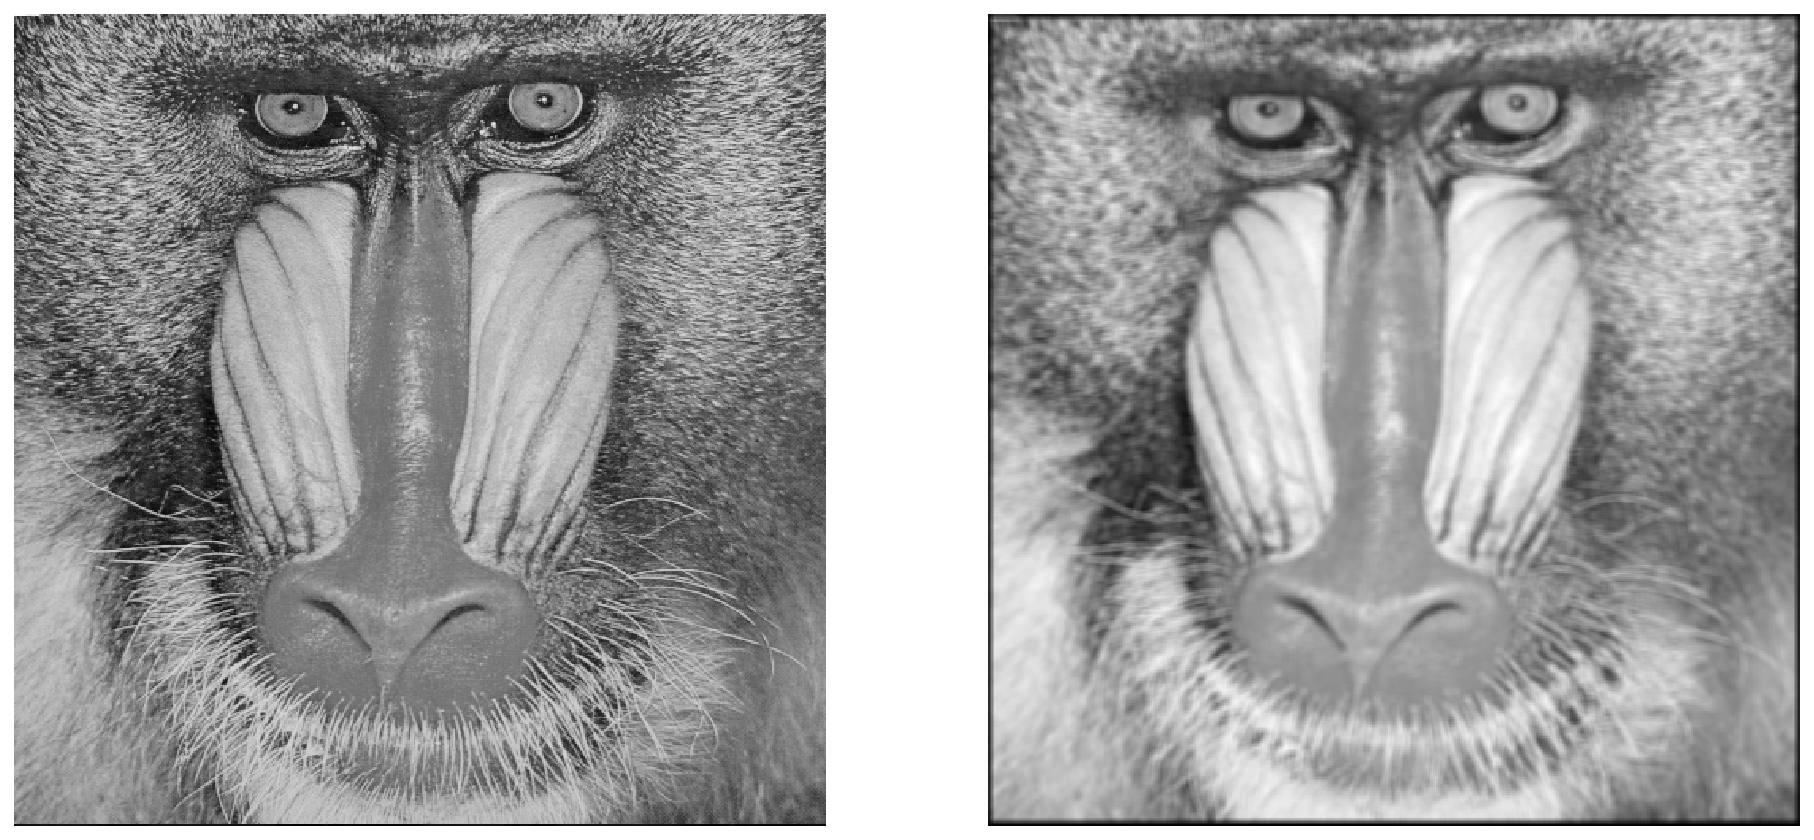

In [4]:
# Plot both the original image and the convolved image
plt.figure(figsize = (16, 16))
plt.plot([1,2,3])
plt.subplot(121)
plt.axis('off')
plt.imshow(original_image, cmap="gray", interpolation="nearest")
plt.subplot(122)
plt.axis('off')
plt.imshow(convolved_image, cmap="gray", interpolation="nearest")

### Saving resulting image

In order to save the resulting image as a BMP file, we need to convert the floats back to `np.int`.

In [5]:
def save_image(array, path, type):
    """Saves the numpy array as image using PIL.Image
    
    Args:
      array: The numpy array.
      path: The path string.
      type: The image file format.
    """
    Image.fromarray(array.astype(np.uint8)).save(path, type)
save_image(convolved_image, "images/convolved.bmp", "BMP")

## Task 2

This task is mainly about adding Gaussian noise to the original image. [Signal-To-Noise Ratio](https://www.signalbooster.com/pages/what-is-signal-to-noise-ratio-snr) is adjusted to create images with different extents of noises.

To implement Gaussian noise, we need to sample float values from a normal distribution with mean $\mu=0$ and variance $\sigma^2=P_{\text{noise}}$. Note that $P_{\text{noise}}$ is also the power of the noise, as used in the computation of SNR:

$$\text{SNR}=\dfrac{\tilde{P}}{P_{\text{noise}}}$$

In order to get the desired SNR value, we need to compute the original power of the image $\tilde{P}$, and compute the variance to generate the additive white noise layer on to the original image. $\tilde{P}$ can be given by:

$$\tilde{P}=\dfrac{\sum_{i=1}^{n}\sum_{j=1}^{n}\text{Image}_{ij}^2}{n^2}$$

where $n$ is the width (and height) of the **square** image.

### Generating additive gaussian noise

> This method resembles the `awgn` (additive white gaussian noise) function in MATLAB.

![](images/noise.svg)


In [6]:
def dB(num):
    """Returns the dB value of a ratio.

    Args:
      num: The input ratio.
    Returns:
      The dB value of the ratio.
    """
    return 20 * np.log10(num)

def dB_inverse(num_db):
    """Returns the ratio.
    
    Args:
      num_db: The ratio scaled in dB unit.
    Returns:
      The numeric ratio.
    """
    return 10 ** (num_db / 20)

# Specify the SNRs to test with
snr = [10, 20, 30]

# Compute the energy of the original image
width, height = convolved_image.shape
P = np.sum(convolved_image ** 2) / width / height
print("The power of the convolved image is", P)

noise_images = {}
convolved_noised_images = {}
# Save three versions of noise matrices
for snr_trial in snr:
    snr_num = dB_inverse(snr_trial)
    variance = P / snr_num
    noise = np.random.normal(0, np.sqrt(variance), (width, height))
    noise_images[snr_trial] = noise
    convolved_noised_images[snr_trial] = noise+convolved_image
    save_image(convolved_noised_images[snr_trial], f"images/convolved_noised_{snr_trial}db.bmp", "BMP")
    save_image(noise, f"images/noise-{snr_trial}db.bmp", "BMP")

The power of the convolved image is 17534.581627209904


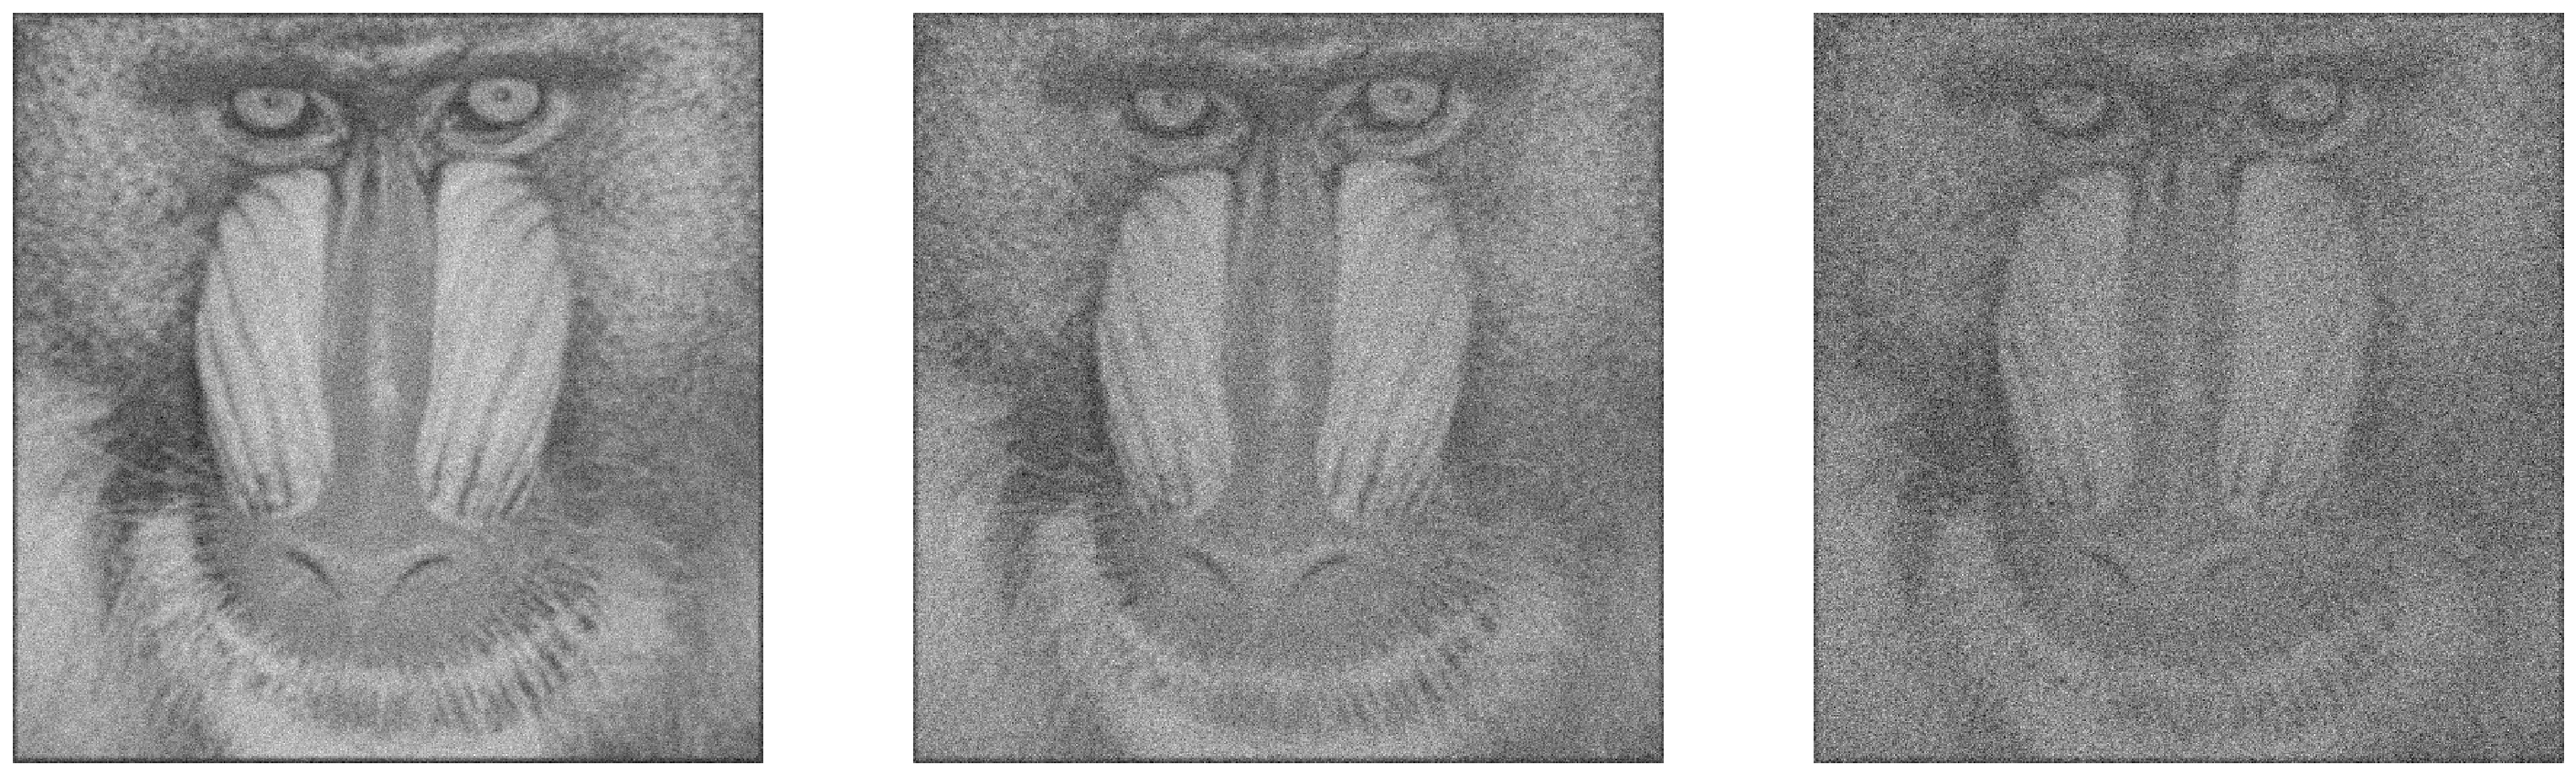

In [7]:
# Plot the three noised images
plt.figure(figsize = (25, 25))
plt.plot([1,3,3])
plt.subplot(131)
plt.axis('off')
plt.imshow(noise_images[30]+convolved_image, cmap="gray", interpolation="nearest")
plt.subplot(132)
plt.axis('off')
plt.imshow(noise_images[20]+convolved_image, cmap="gray", interpolation="nearest")
plt.subplot(133)
plt.axis('off')
plt.imshow(noise_images[10]+convolved_image, cmap="gray", interpolation="nearest")

While saving the images to BMP files, we note that some white spots can be found surrounded by darker pixels. Personally I believe this is normal due to the nature of Gaussian distribution and owes simply to randomness.

## Task 3

This task involves cleaning the convolved, noised images using deconvolution and Wiener filter.

### Deconvolution as division on frequency domain

From previous knowledge from Signals and Systems course, in order to deconvolve an image, we simply need to apply Fourier Transform to the original image and the kernel, and perform **Hadamard division**. 

Given $x(t) \xLeftrightarrow{\mathcal{FT}} X(f), y(t) \xLeftrightarrow{\mathcal{FT}} Y(f), h(t) \xLeftrightarrow{\mathcal{FT}} H(f)$ and $x(t) * h(t) = y(t)$, we can deduce that $X(f) \cdot H(f) = Y(f)$, therefore:

$$X(f) = \dfrac{Y(f)}{H(f)}$$

In fact, all the signals are discrete, and the frequencies are limited to a certain range of "pixels".

![](images/deconv.svg)


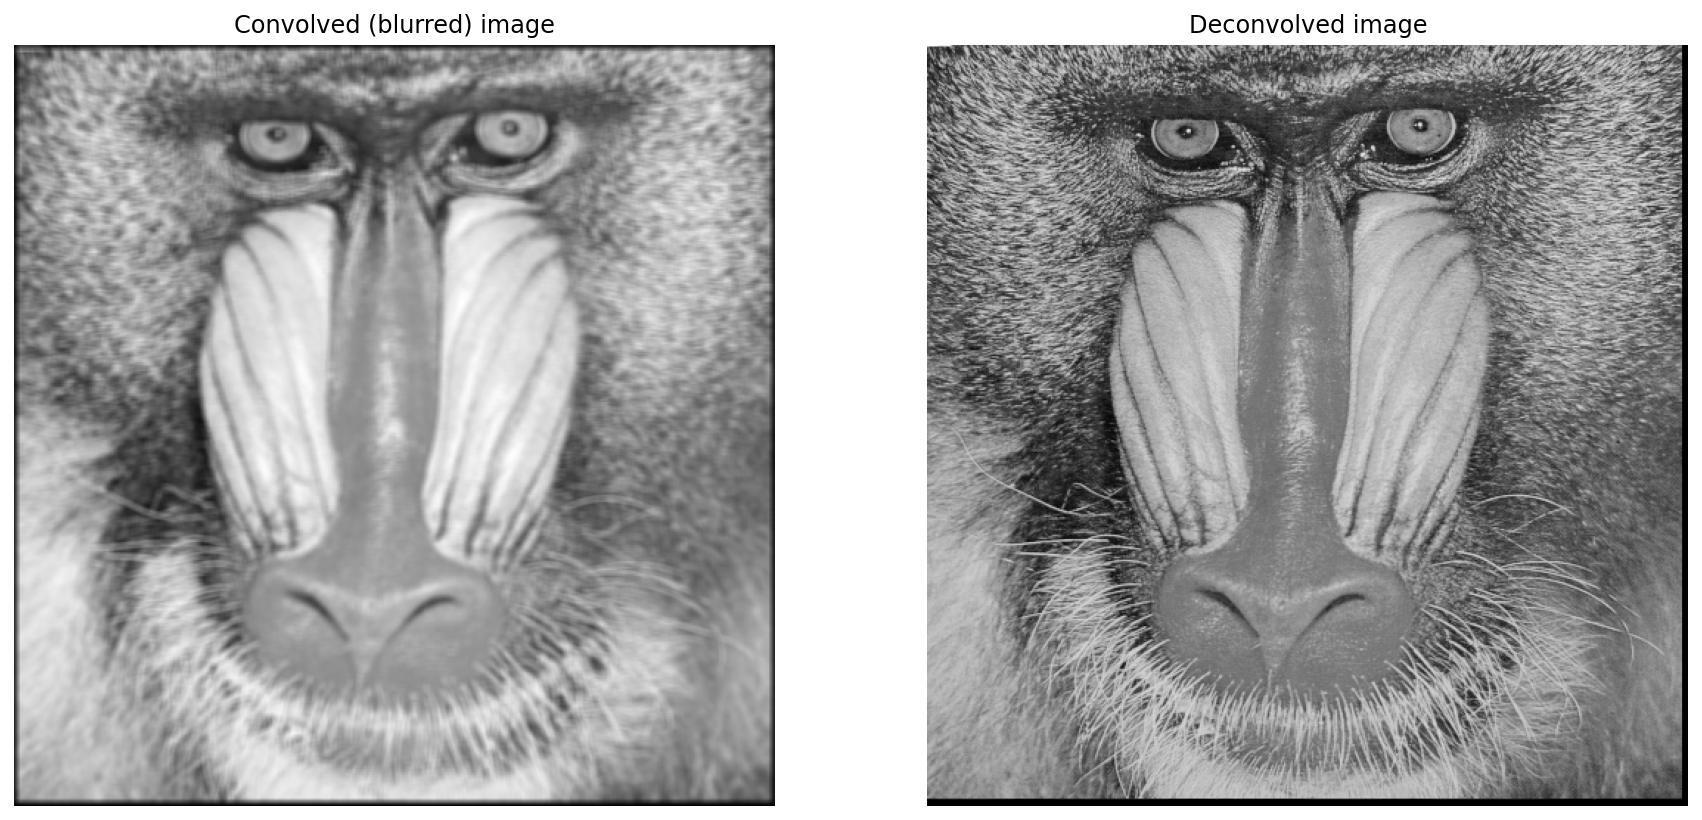

In [8]:
# We are never going to touch the convolved noised images, and focus on treating
# the processed images.
blurry_images = convolved_noised_images.copy()
import numpy.fft as fft

def deconvolution(image, kernel):
    """Deconvolves the image by the kernel using basic 2D fourier transform
    
    Args: 
        image: The image to be deconvolved.
        kernel: The kernel to be deconvolved.
    Returns:
        The deconvolved image.
    """
    # Perform 2D Fourier Transform
    image_fft = fft.fft2(image)
    kernel_fft = fft.fft2(kernel, image.shape)
    # Get the deconvolved image by performing Hadamard division
    deconvolvedImage = fft.ifft2(image_fft / kernel_fft)
    return deconvolvedImage
    
# Deconvolve the blurred images
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title("Convolved (blurred) image")
plt.axis('off')
plt.imshow(convolved_image, 'gray')
plt.subplot(122)
plt.title("Deconvolved image")
plt.axis('off')
plt.imshow(np.abs(deconvolution(convolved_image, kernel)), 'gray')

The results are very different when perfoming deconvolution on noised, blurred images.

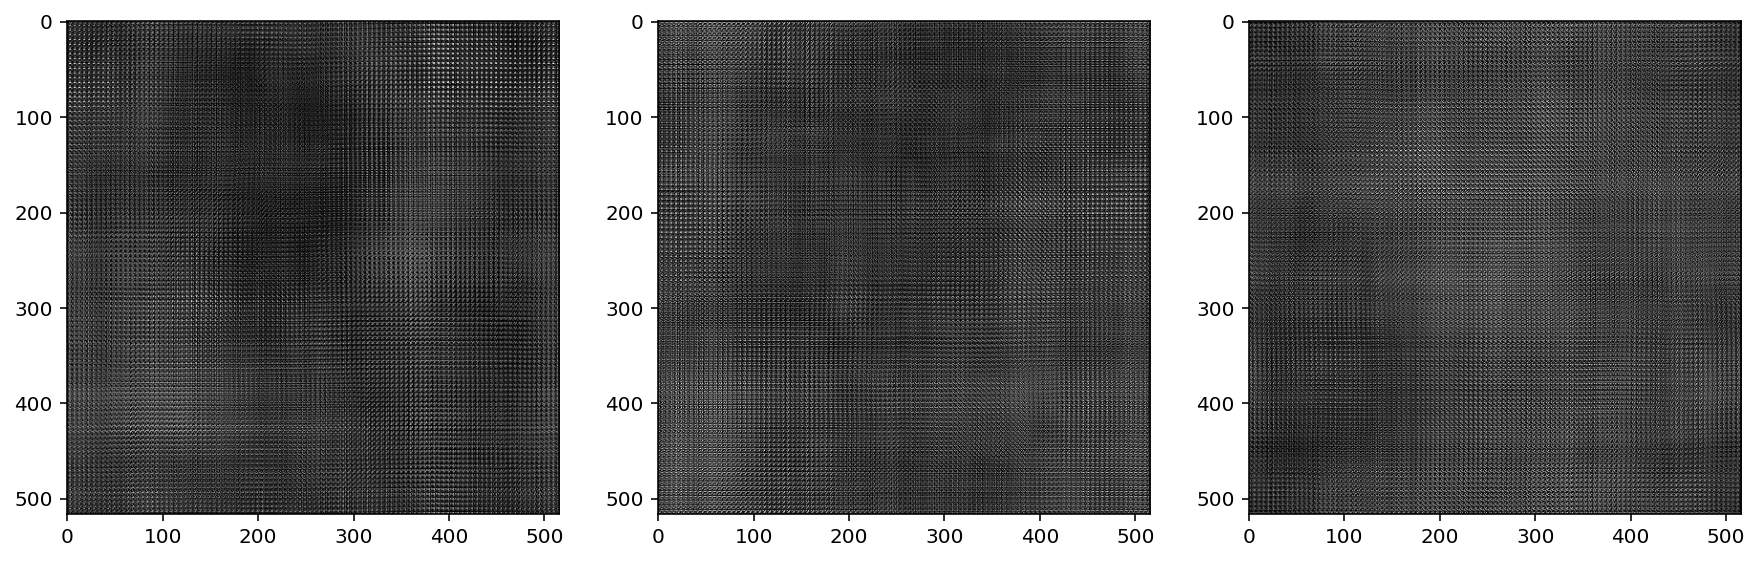

In [9]:
deconvolved_images = {}
c = 0
plt.figure(figsize=(15, 15))
for snr_trial in snr:
    c += 1
    deconvolved_images[snr_trial] = deconvolution(blurry_images[snr_trial], kernel)
    plt.subplot(130 + c)
    plt.imshow(np.abs(deconvolved_images[snr_trial]), 'gray')

This is quite expected, as the noise applied ruins the Fourier Transform process. The deconvolution is not a good idea when any noise is applied.


### Wiener filter using `skimage`

Before diving deep into Wiener filter and how I could use it, I'd use a premade function in `skimage` to perform the deconvolution, as documented [here](https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.unsupervised_wiener).

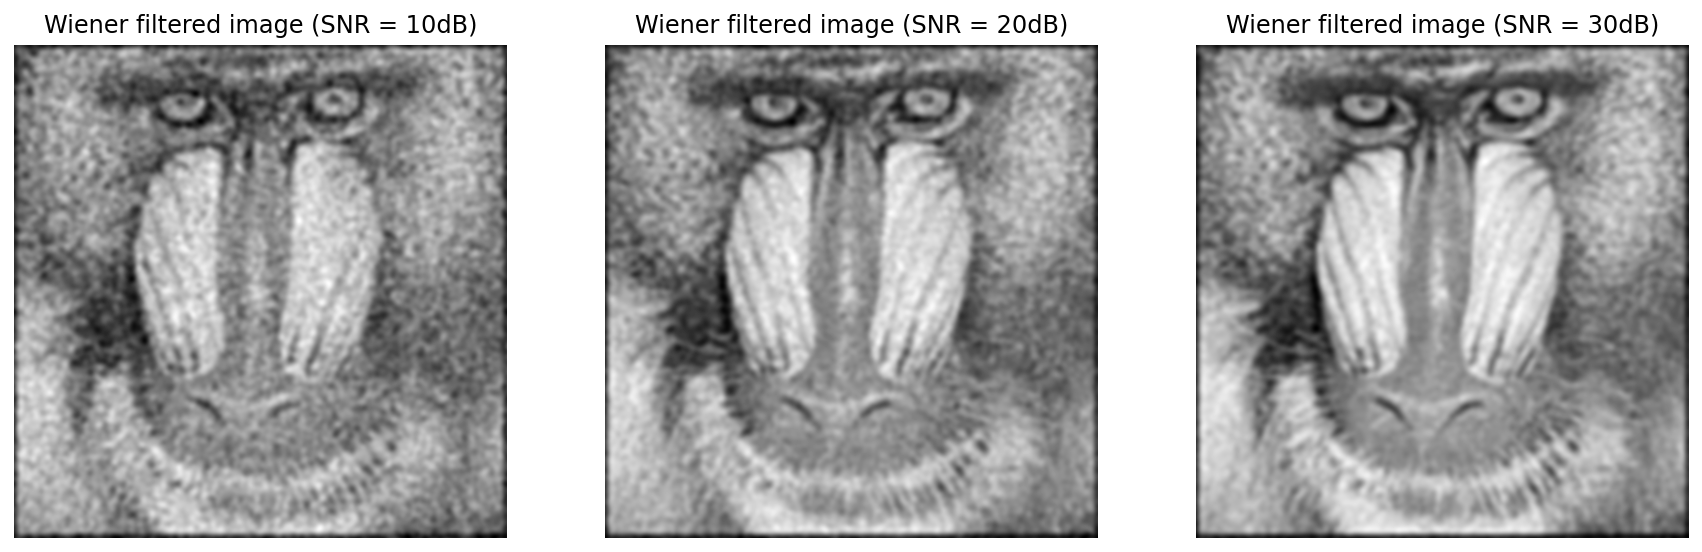

In [10]:
# Using Wiener filter from scikit-image
from skimage import restoration

skimage_wiener_filtered = {}

for snr_trial in snr:
    # Deconvolve using Wiener filter
    skimage_wiener_filtered[snr_trial] = restoration.wiener(blurry_images[snr_trial], kernel, 10, clip=False)

# Plot the Wiener filtered images
plt.figure(figsize=(15, 15))
c = 0
for snr_trial in snr:
    c += 1
    plt.subplot(130 + c)
    plt.title("Wiener filtered image (SNR = " + str(snr_trial) + "dB)")
    plt.axis("off")
    plt.imshow(np.abs(skimage_wiener_filtered[snr_trial]), 'gray')

# Saving the Wiener filtered images
for snr_trial in snr:
    save_image(skimage_wiener_filtered[snr_trial], f"images/wiener_filtered_skimage_{snr_trial}db.bmp", "BMP")

We see a significant increase in image quality when using the Wiener filter. At least it gives us a way to unblur the noised image.

So what is Wiener filter actually doing under the hood?

## Wiener filter from scratch

The maths behind was found [here](https://en.wikipedia.org/wiki/Wiener_filter) and [here](https://en.wikipedia.org/wiki/Wiener_deconvolution).

Our target is to minimize the mean square error, which may be expressed as:

Given a system:

$$\displaystyle y(t)=(h*x)(t)+n(t)$$

where $\displaystyle *$ denotes convolution and:

- $x(t)$ is some original signal (unknown) at time $t$.
- $h(t)$ is the known impulse response of a linear time-invariant system.
- $n(t)$ is some unknown additive noise, independent of $x(t)$.
- $y(t)$ is our observed signal.

Our goal is to find some $g(t)$ so that we can estimate $x(t)$ as follows:

$${\hat {x}}(t)=(g*y)(t)$$

where ${\hat {x}}(t)$ is an estimate of $x(t)$ that minimizes the mean square error

$$\epsilon (t)=\mathbb {E} \left|x(t)-{\hat {x}}(t)\right|^{2}$$

with $\mathbb {E} $ denoting the expectation.

> The Wiener deconvolution filter provides such a $g(t)$. The filter is most easily described in the frequency domain:
> 
> $$G(f)={\frac {H^{*}(f)S(f)}{|H(f)|^{2}S(f)+N(f)}}$$
> 
> where:
> 
> - $G(f)$ and $H(f)$ are the Fourier transforms of $g(t)$ and $h(t)$,
> - $S(f)=\mathbb {E} |X(f)|^{2}$ is the mean power spectral density of the original signal $x(t)$,
> - $N(f)=\mathbb {E} |V(f)|^{2}$ is the mean power spectral density of the noise $n(t)$,
> - $X(f)$, $Y(f)$ and $V(f)$ are the Fourier transforms of $x(t)$, and $y(t)$, and $n(t)$, respectively,
> - the superscript $^*$ denotes complex conjugation.
> The filtering operation may either be carried out in the time-domain, as above, or in the frequency domain:
> 
> $${\hat {X}}(f)=G(f)Y(f)$$
> 
> and then performing an inverse Fourier transform on ${\hat {X}}(f)$ to obtain ${\hat {x}}(t)$.
> 
> Note that in the case of images, the arguments $t$ and $f$ above become two-dimensional; however the result is the same.

From the above explanation, I implemented the filter as follows:

In [11]:
def wiener_filter(image, kernel, K = 10):
    """Filters the original image by the kernel using Wiener filter.

    Args:
      image: The image to be filtered.
      kernel: The kernel to be used for filtering.
      K: The clipping constant.

    Returns:
      The filtered image.
    """
    img = np.copy(image)
    kernel = np.pad(kernel, [(0, img.shape[0] - kernel.shape[0]), (0, img.shape[1] - kernel.shape[1])], 'constant')
    img = fft.fft2(img)
    kernel = fft.fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    img = img * kernel
    img = np.abs(fft.ifft2(img))
    return np.uint8(img)

Now we test the filter with the blurry images with noises.

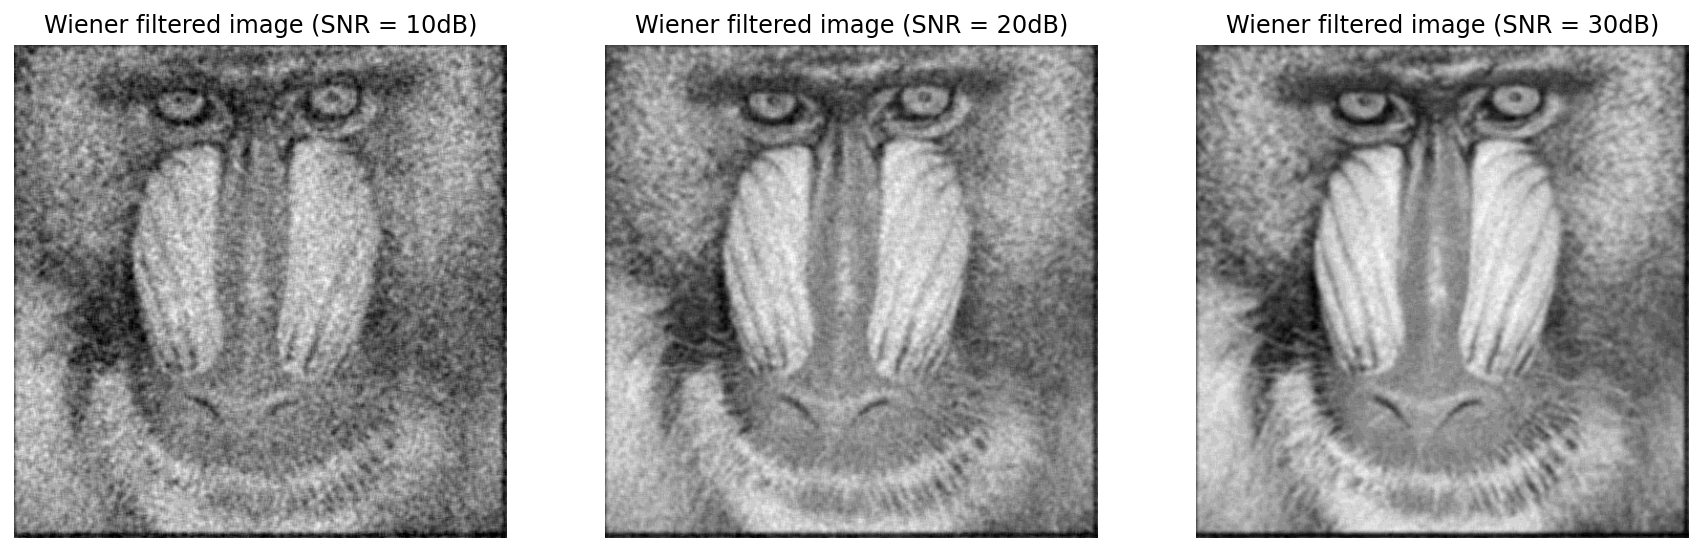

In [12]:
my_wiener_filtered = {}

for snr_trial in snr:
    # Deconvolve using Wiener filter
    my_wiener_filtered[snr_trial] = wiener_filter(blurry_images[snr_trial], kernel)

# Plot the Wiener filtered images
plt.figure(figsize=(15, 15))
c = 0
for snr_trial in snr:
    c += 1
    plt.subplot(130 + c)
    plt.title("Wiener filtered image (SNR = " + str(snr_trial) + "dB)")
    plt.axis("off")
    plt.imshow(np.abs(my_wiener_filtered[snr_trial]), 'gray')

# Saving the Wiener filtered images
for snr_trial in snr:
    save_image(my_wiener_filtered[snr_trial], f"images/wiener_filtered_{snr_trial}db.bmp", "BMP")

We are able to see that the results is very much alike to the `skimage` implementation.

## Note: Why deconvolution does not work without proper padding?

During the process of completing the task, I noticed that without proper padding to the original image, the deconvolution process will not work properly. The results acquired from the inverse Fourier Transform will be affected with a 

This is predictable by Shannon's information theory: **If we do not properly pad the original image, the signal information is partially lost.** But convolution with padding should be a reversible and lossless action, so is deconvolution itself. Without proper padding, we are not able reconstruct the original image.

In addition, when we perform 2D Fast Fourier Transform on the noisy, blurred image, we are assuming that the signal is finite in length, and thus extending it to a infinite-length periodic signal. If we do not pad the image properly, this process will generate errorneous results at the boundaries of the image, producing wrong results. That's why we are expected to see a high frequency noise in the output. In fact, the noise has a frequency related to the dimension of the original image. (Tested with downscaled images with 128x128 and upscaled images with 2048x2048.)

## Special Thanks

During the process of completing the project, I received lots of help from Prof. Yuye Ling. Thanks for his patience and support.

The TAs of the lecture are also very responsible as they allow the use of Python (in addition to MATLAB) to complete this programming homework. Without the help of Python, I may not be able to construct basic understandings on convolution and deconvolution (and Fourier Transform as well).

## License

The above code are under MIT License. The image `baboon.bmp` is copyrighted by the original author.
